## Helper Methods
- Tools we may use later for data pre-processing and graphing

In [104]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from pathlib import Path
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, concatenate, Lambda, BatchNormalization, Activation, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, mean_squared_error
import matplotlib.pyplot as plt 
from collections.abc import Sequence
from sklearn import preprocessing
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

BASE_PATH = "./"

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,sort = True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by = ['y'],inplace = True)
    a = plt.plot(t['pred'].tolist(), ls = '', marker='s', markersize = 1.0, label = 'prediction', color = 'orange')
    b = plt.plot(t['y'].tolist(), label = 'expected', color = 'blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
#custom function for sliding window x/y data split
def create_sliding_window_data(df, close_unnormalized, window_size):
    x = []
    y = []
    for i in range(window_size, len(df)):
        #get window_size days of data (rows i-window_size to i-1)
        window = df.iloc[i-window_size:i].values
        x.append(window.flatten())
        y.append(close_unnormalized[i])
    return np.array(x), np.array(y)


## Set up Environment
Create test output folders and define paths 

In [ ]:
base_path=os.path.join(os.getcwd(), './test-output/')

iteration='FCNN-Search-2'
full_path = os.path.join(base_path, iteration)
try:
        os.mkdir(full_path)
except Exception as e:
     print(f"Probably safe to ignore the following error: \n{e}")


## Data Extraction

In [ ]:
#read dataset and format
from sklearn.model_selection import train_test_split
TXT_DATASET_LOCATION = "./business-dataset/RDS-B.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)


split_raw = int(len(df) * 0.7)
df_train = df.iloc[:split_raw].copy()
df_test  = df.iloc[split_raw:].copy()


train_means = {}
train_stds  = {}

for col in df_train.columns:
    mean = df_train[col].mean()
    sd   = df_train[col].std()
    train_means[col] = mean
    train_stds[col]  = sd
    
    # so test normalization does not peek at the future.
    encode_numeric_zscore(df_train, col, mean=mean, sd=sd)
    # normalize TEST using the same mean/sd. Used to avoid leakage
    encode_numeric_zscore(df_test, col, mean=mean, sd=sd)

window_size = 7

# keep separate unnormalized close values for each split
close_train = df["Close"].iloc[:split_raw].values.copy()
close_test  = df["Close"].iloc[split_raw:].values.copy()

x_train, y_train = create_sliding_window_data(df_train, close_train, window_size)
x_test,  y_test  = create_sliding_window_data(df_test,  close_test,  window_size)




## Data Split

In [107]:
#XY split

window_size = 7
n_features = 5

#creating split for each model 
#Base aka FCNN
x_train_flat, y_train_base = x_train.copy(), y_train.copy()
x_test_flat, y_test_base = x_test.copy(), y_test.copy()

x_train_cnn = x_train.reshape(-1, 7, 5, 1)
x_test_cnn = x_test.reshape(-1, 7, 5, 1)

#for LSTM (3D) 
x_train_lstm = x_train.reshape(-1, 7, 5)
x_test_lstm = x_test.reshape(-1, 7, 5)



## LSTM Model

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
#save the best model
window_size = 7
n_features = 5

# Reshape for LSTM
#LSTM checkpoint
LSTMcheckpointer = ModelCheckpoint(filepath=full_path + "/best_LSTMweights.keras", monitor="val_loss", save_best_only = True) 
#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.001)
for i in range(1):
    print(i)
    #build the network
    LSTM_model = Sequential()

    LSTM_model.add(Bidirectional((LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, input_shape=(window_size, n_features)))))
    LSTM_model.add(Dense(32, activation="relu"))
    LSTM_model.add(Dropout(0.1))
    LSTM_model.add(Dense(16, activation="relu"))
    LSTM_model.add(Dense(1, activation="linear"))
   

    #model compilation
    LSTM_model.compile(loss = 'mean_squared_error', optimizer = Adam(1e-3))
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1, mode="auto")
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model



# Train correct model
history = LSTM_model.fit(
    x_train_lstm, y_train_base,
    validation_data=(x_test_lstm, y_test_base),
    epochs=1000,
    batch_size=64,
    shuffle=False,
    callbacks=[LSTMcheckpointer, monitor],
    verbose=1
)
print('Training finished...Loading the best model')  
print()


0
Epoch 1/1000


c:\Users\snowt\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1061.3660 - val_loss: 3324.1562
Epoch 2/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 334.5233 - val_loss: 110.7000
Epoch 3/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 167.8637 - val_loss: 250.5465
Epoch 4/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 114.4705 - val_loss: 181.6400
Epoch 5/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 103.1708 - val_loss: 163.3487
Epoch 6/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 92.2877 - val_loss: 153.4201
Epoch 7/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 79.1631 - val_loss: 143.1445
Epoch 8/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 63.6167 - val_loss: 110.4124
Epoch 9/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 54.0865 - val_loss: 87.7049
Epoch 10/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 43.0788 - val_loss: 60.4185
Epoch 11/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 38.7695 - val_loss: 54.9670
Epoch

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Score LSTM (RMSE): 3.4325507811087093



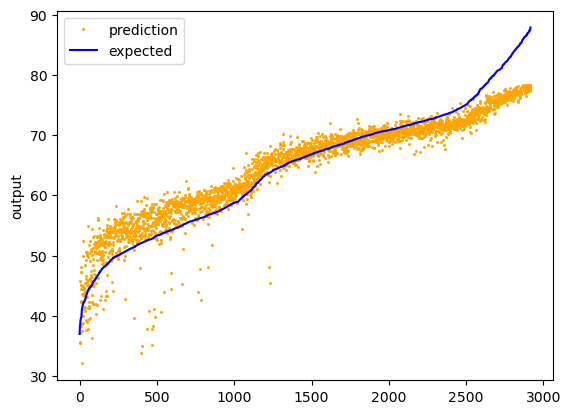

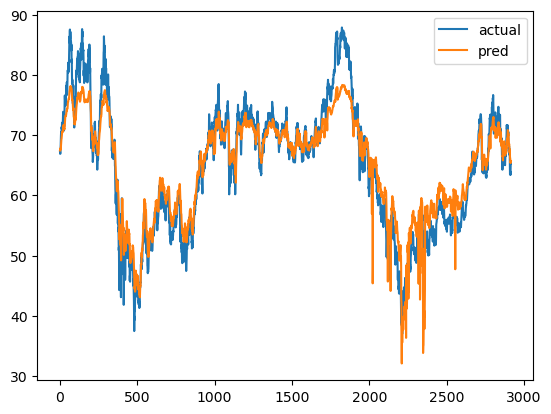

(2917, 1)
Score LSTM (RMSE): 3.4326
Saved: c:\Users\snowt\OneDrive\Documents\CSC-180\project4\submissionVersion\bchurch2-Time-Series-Forecasting\./test-output/FCNN-Search-2\lstm_regression_unsorted.png
Saved: c:\Users\snowt\OneDrive\Documents\CSC-180\project4\submissionVersion\bchurch2-Time-Series-Forecasting\./test-output/FCNN-Search-2\lstm_regression_sorted.png
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [109]:
LSTM_model.load_weights(full_path + '/best_LSTMweights.keras')
y_pred_lstm= LSTM_model.predict(x_test_lstm)
from tensorflow.keras.losses import Huber
#rmse score
rmse_LSTM = np.sqrt(metrics.mean_squared_error(y_test_base,y_pred_lstm))
print("Score LSTM (RMSE): {}".format(rmse_LSTM))


print("")
chart_regression(y_pred_lstm.flatten(),y_test_base, sort = True)

plt.plot(y_test_base, label="actual")
plt.plot(y_pred_lstm.flatten(), label="pred")
plt.legend(); plt.show()
print(y_pred_lstm.shape)


LSTM_model.load_weights(os.path.join(full_path, "best_LSTMweights.keras"))
y_pred_lstm = LSTM_model.predict(x_test_lstm, verbose=0).flatten()

rmse_LSTM = np.sqrt(metrics.mean_squared_error(y_test_base, y_pred_lstm))
print(f"Score LSTM (RMSE): {rmse_LSTM:.4f}")

# Build a DataFrame for easy sorting/plotting
df_plot = pd.DataFrame({
    "actual": y_test_base.flatten(),
    "pred": y_pred_lstm
})

#Plot for unsorted
plt.figure(figsize=(10, 5))
plt.plot(df_plot.index, df_plot["actual"], label="Actual", linewidth=1.5)
plt.plot(df_plot.index, df_plot["pred"],   label="Prediction", linewidth=1.5)
plt.title(f"LSTM Predictions (Unsorted) — RMSE: {rmse_LSTM:.4f}")
plt.xlabel("Time index (test set order)")
plt.ylabel("Close (target units)")
plt.legend()
plt.grid(True, alpha=0.3)
unsorted_path = os.path.join(full_path, "lstm_regression_unsorted.png")
plt.savefig(unsorted_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {unsorted_path}")

#Plot for sorted
df_sorted = df_plot.sort_values("actual").reset_index(drop=True)

plt.figure(figsize=(10, 5))
plt.plot(df_sorted.index, df_sorted["pred"],   label="Prediction (sorted by actual)", linewidth=1.5)
plt.plot(df_sorted.index, df_sorted["actual"], label="Actual (sorted)", linewidth=1.5)
plt.title(f"LSTM Predictions (Sorted by Actual) — RMSE: {rmse_LSTM:.4f}")
plt.xlabel("Sample index (sorted by actual)")
plt.ylabel("Close (target units)")
plt.legend()
plt.grid(True, alpha=0.3)
sorted_path = os.path.join(full_path, "lstm_regression_sorted.png")
plt.savefig(sorted_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {sorted_path}")
plot_model(LSTM_model)


## FCNN Model


In [110]:
#save the best model
from tensorflow.keras.optimizers import SGD
checkpointer = ModelCheckpoint(filepath= full_path + "/best_FCNNweights1.keras", verbose = 0, save_best_only = True) 
#optimizer definition (Adam)
optimizer = SGD(learning_rate = 0.0001)
for i in range(10):
    print(i)
    #build the network
    model_FCNN = Sequential()
    model_FCNN.add(Dense(64, input_dim = x_train_flat.shape[1], activation = "relu"))
    model_FCNN.add(Dropout(0.3))
    model_FCNN.add(Dense(32, activation = "relu"))
    model_FCNN.add(Dropout(0.2))
    model_FCNN.add(Dense(16, activation = "relu"))
    model_FCNN.add(Dense(1, activation = "linear"))
   

    #model compilation
    model_FCNN.compile(loss = 'mean_squared_error', optimizer = optimizer)
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model
    history = model_FCNN.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 300, batch_size = 64, shuffle=False, callbacks = [monitor, checkpointer], verbose = 1)
    print('Training finished...Loading the best model')  
    print()

    

0
Epoch 1/300


c:\Users\snowt\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 429.4284 - val_loss: 120.8554
Epoch 2/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133.1947 - val_loss: 97.6499
Epoch 3/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131.5727 - val_loss: 115.6258
Epoch 4/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108.0680 - val_loss: 101.5792
Epoch 5/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.0388 - val_loss: 142.4196
Epoch 6/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74.8021 - val_loss: 81.6685
Epoch 7/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.5037 - val_loss: 95.3728
Epoch 8/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.4491 - val_loss: 54.4396
Epoch 9/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.8033 - val_loss: 152.1114
Epoch 10/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.7180 - val_loss: 196.1781
Epoch 11/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.9065 - val_loss: 109.9780
Epoch 12/300
107/107

In [111]:
model_FCNN.load_weights(full_path + '/best_FCNNweights1.keras')

c:\Users\snowt\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## FCNN Graphing

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
(2917, 1)
Score (RMSE): 4.114536036217639


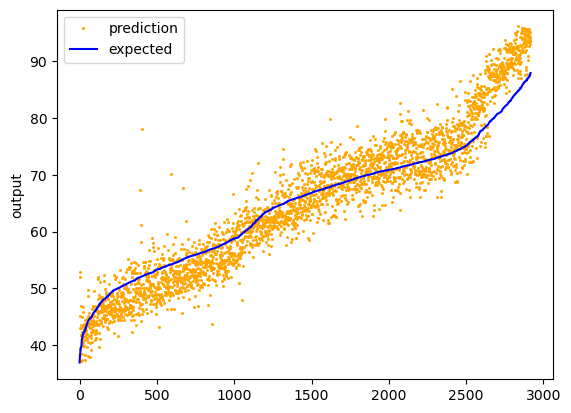

Score FCNN (RMSE): 4.1145
Saved: c:\Users\snowt\OneDrive\Documents\CSC-180\project4\submissionVersion\bchurch2-Time-Series-Forecasting\./test-output/FCNN-Search-2\fcnn_regression_unsorted.png
Saved: c:\Users\snowt\OneDrive\Documents\CSC-180\project4\submissionVersion\bchurch2-Time-Series-Forecasting\./test-output/FCNN-Search-2\fcnn_regression_sorted.png


In [112]:
#make predictions
y_pred = model_FCNN.predict(x_test_flat)
print(y_pred.shape)

#rmse score
rmse_FCNN= np.sqrt(metrics.mean_squared_error(y_test_base, y_pred))
print("Score (RMSE): {}".format(rmse_FCNN))
chart_regression(y_pred.flatten(),y_test_base, sort = True)

y_pred_fcnn = model_FCNN.predict(x_test_flat, verbose=0).flatten()
rmse_FCNN = np.sqrt(metrics.mean_squared_error(y_test_base, y_pred_fcnn))
print(f"Score FCNN (RMSE): {rmse_FCNN:.4f}")

# Build a dataframe for plotting
df_fcnn = pd.DataFrame({"actual": y_test_base.flatten(), "pred": y_pred_fcnn})

#unsorted
plt.figure(figsize=(10, 5))
plt.plot(df_fcnn.index, df_fcnn["pred"],   label="Prediction", linewidth=1.5)
plt.plot(df_fcnn.index, df_fcnn["actual"], label="Actual", linewidth=1.5)
plt.title(f"FCNN Predictions (Unsorted) — RMSE: {rmse_FCNN:.4f}")
plt.xlabel("Time index (test set order)")
plt.ylabel("Adjusted Close (target units)")
plt.legend()
plt.grid(True, alpha=0.3)
path_unsorted_fcnn = os.path.join(full_path, "fcnn_regression_unsorted.png")
plt.savefig(path_unsorted_fcnn, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {path_unsorted_fcnn}")

#sorted
df_fcnn_sorted = df_fcnn.sort_values("actual").reset_index(drop=True)
plt.figure(figsize=(10, 5))
plt.plot(df_fcnn_sorted.index, df_fcnn_sorted["pred"],   label="Prediction (sorted by actual)", linewidth=1.5)
plt.plot(df_fcnn_sorted.index, df_fcnn_sorted["actual"], label="Actual (sorted)", linewidth=1.5)
plt.title(f"FCNN Predictions (Sorted by Actual) — RMSE: {rmse_FCNN:.4f}")
plt.xlabel("Sample index (sorted by actual)")
plt.ylabel("Close (target units)")
plt.legend()
plt.grid(True, alpha=0.3)
path_sorted_fcnn = os.path.join(full_path, "fcnn_regression_sorted.png")
plt.savefig(path_sorted_fcnn, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {path_sorted_fcnn}")


In [113]:
x_train.shape

(6813, 35)

## CNN Model


In [114]:
#save the best model
CNNcheckpointer = ModelCheckpoint(filepath= full_path + "/best_CNNweights.keras", verbose = 0, save_best_only = True) 

#optimizer definition (Adam)
optimizer = SGD(learning_rate = 0.0001)
for i in range(1):
    print(i)
    #build the network

    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                        input_shape=(7, 5, 1)))
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.25))

    CNN_model.add(Flatten())
    CNN_model.add(Dense(64, activation="relu"))
    CNN_model.add(Dropout(0.25))
    CNN_model.add(Dense(1, activation="linear"))
    

#model compilation
CNN_model.compile(loss = 'mean_squared_error', optimizer = optimizer)
#early stopping
monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
#optimizer
optimizer = Adam(learning_rate = 0.0001)

#train model

#Train correct model
history = CNN_model.fit(
    x_train_cnn, y_train_base,
    validation_data=(x_test_cnn, y_test_base),
    epochs=1000,
    batch_size=64,
    shuffle=False,
    callbacks=[CNNcheckpointer, monitor],
    verbose=1
)
print('Training finished...Loading the best model')  
print()

0
Epoch 1/1000


c:\Users\snowt\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 686.9038 - val_loss: 254.3479
Epoch 2/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95.4931 - val_loss: 112.1136
Epoch 3/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80.8367 - val_loss: 47.7530
Epoch 4/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.6917 - val_loss: 19.7065
Epoch 5/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.1101 - val_loss: 442.4151
Epoch 6/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.3642 - val_loss: 41.5336
Epoch 7/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.4495 - val_loss: 15.5064
Epoch 8/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.0342 - val_loss: 492.4119
Epoch 9/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.5876 - val_loss: 103.8225
Epoch 10/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.1317 - val_loss: 16.4410
Epoch 11/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.1444 - val_loss: 49.2211
Epoch 12/1000
1

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(2917, 1)
Score LSTM (RMSE): 3.4325507811087093
Score CNN (RMSE): 2.615195747477326
Score FCNN (RMSE): 4.114536036217639


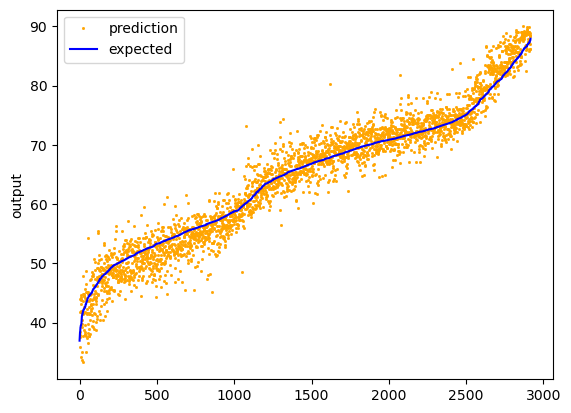

Score CNN (RMSE): 2.6708
Saved: c:\Users\snowt\OneDrive\Documents\CSC-180\project4\submissionVersion\bchurch2-Time-Series-Forecasting\./test-output/FCNN-Search-2\cnn_regression_unsorted.png
 Saved: c:\Users\snowt\OneDrive\Documents\CSC-180\project4\submissionVersion\bchurch2-Time-Series-Forecasting\./test-output/FCNN-Search-2\cnn_regression_sorted.png


In [ ]:
CNN_model.load_weights(full_path + '/best_CNNweights.keras')
y_other_pred = CNN_model.predict(x_test_cnn)
print(y_other_pred.shape)

#rmse score
rmse_CNN = np.sqrt(metrics.mean_squared_error(y_test_base,y_other_pred))
print("Score LSTM (RMSE): {}".format(rmse_LSTM))
print("Score CNN (RMSE): {}".format(rmse_CNN))
print("Score FCNN (RMSE): {}".format(rmse_FCNN))
chart_regression(y_other_pred.flatten(),y_test_base, sort = True)

# CNN prediction
CNN_model.load_weights(os.path.join(full_path, "best_CNNweights.keras"))
y_pred_cnn = CNN_model.predict(x_test_cnn, verbose=0).flatten()
rmse_CNN = np.sqrt(metrics.mean_squared_error(y_test_base, y_pred_cnn))
print(f"Score CNN (RMSE): {rmse_CNN:.4f}")

# Build a DataFrame for plotting
df_cnn = pd.DataFrame({"actual": y_test_base.flatten(), "pred": y_pred_cnn})

#unsorted 
plt.figure(figsize=(10, 5))
plt.plot(df_cnn.index, df_cnn["actual"], label="Actual", linewidth=1.5)
plt.plot(df_cnn.index, df_cnn["pred"],   label="Prediction", linewidth=1.0)
plt.title(f"CNN Predictions (Unsorted) — RMSE: {rmse_CNN:.4f}")
plt.xlabel("Time index (test set order)")
plt.ylabel("Close (target units)")
plt.legend()
plt.grid(True, alpha=0.3)
path_unsorted_cnn = os.path.join(full_path, "cnn_regression_unsorted.png")
plt.savefig(path_unsorted_cnn, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {path_unsorted_cnn}")

#sorted
df_cnn_sorted = df_cnn.sort_values("actual").reset_index(drop=True)
plt.figure(figsize=(10, 5))
plt.plot(df_cnn_sorted.index, df_cnn_sorted["pred"],   label="Prediction (sorted by actual)", linewidth=1.5)
plt.plot(df_cnn_sorted.index, df_cnn_sorted["actual"], label="Actual (sorted)", linewidth=1.5)

plt.title(f"CNN Predictions (Sorted by Actual) — RMSE: {rmse_CNN:.4f}")
plt.xlabel("Sample index (sorted by actual)")
plt.ylabel("Close (target units)")
plt.legend()
plt.grid(True, alpha=0.3)
path_sorted_cnn = os.path.join(full_path, "cnn_regression_sorted.png")
plt.savefig(path_sorted_cnn, dpi=300, bbox_inches='tight')
plt.close()
print(f" Saved: {path_sorted_cnn}")



In [116]:
import json
rmse_results = {
    "FCNN": rmse_FCNN,
    "CNN": rmse_CNN,
    "LSTM": rmse_LSTM
}

# save to the same directory used for model weights
save_path = os.path.join(full_path, "rmse_results.json")
with open(save_path, "w") as f:
    json.dump(rmse_results, f, indent=4)

print(f"Saved RMSE results to {save_path}")


Saved RMSE results to c:\Users\snowt\OneDrive\Documents\CSC-180\project4\submissionVersion\bchurch2-Time-Series-Forecasting\./test-output/FCNN-Search-2\rmse_results.json


## EC: RMSE Against N Value
Using the FCNN

In [117]:
#read dataset and format
from sklearn.model_selection import train_test_split
TXT_DATASET_LOCATION = "./business-dataset/RDS-B.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)

#split data 
split_raw = int(len(df) * 0.7)
df_train = df.iloc[:split_raw].copy()
df_test  = df.iloc[split_raw:].copy()

train_means = {}
train_stds  = {}

for col in df_train.columns:
    mean = df_train[col].mean()
    sd   = df_train[col].std()
    train_means[col] = mean
    train_stds[col]  = sd

    # normalize TRAIN in place
    encode_numeric_zscore(df_train, col, mean=mean, sd=sd)
    # normalize TEST using the same mean/sd (no leakage)
    encode_numeric_zscore(df_test, col, mean=mean, sd=sd)

# keep separate unnormalized close values for each split
close_train = df["Close"].iloc[:split_raw].values.copy()
close_test  = df["Close"].iloc[split_raw:].values.copy()

#normalize data (separate from close_unnormalized)
for col in df.columns:
    encode_numeric_zscore(df, col)

### Window size 3

In [118]:
#save the best model across all iterations
checkpointer = ModelCheckpoint(filepath="dnn/best_FCNNweights2.keras", verbose=0, save_best_only=True) 

#window size 3
window_size = 3
x1_train, y1_train = create_sliding_window_data(df_train, close_train, window_size)
x1_test,  y1_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss1 = np.inf
best_model_weights1 = None
best_iteration1 = 0

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model1 = Sequential()
    model1.add(Dense(64, input_dim=x1_train.shape[1], activation="relu"))
    model1.add(Dropout(0.3))
    model1.add(Dense(32, activation="relu"))
    model1.add(Dropout(0.2))
    model1.add(Dense(16, activation="relu"))
    model1.add(Dense(1, activation="linear"))
    
    #model compilation
    model1.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history1 = model1.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
                         epochs=1000, batch_size=64, shuffle=False,
                         callbacks=[monitor, checkpointer], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss1 = min(history1.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss1 < best_val_loss1:
        best_val_loss1 = current_val_loss1
        best_model_weights1 = model1.get_weights()
        best_iteration1 = i + 1
    
    print()

#save the best model weights from all iterations
model1.set_weights(best_model_weights1)
model1.save("dnn/best_FCNNweights2_overall.keras")


c:\Users\snowt\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Window size 5

In [119]:
#save the best model across all iterations
checkpointer2 = ModelCheckpoint(filepath="dnn/best_FCNNweights3.keras", verbose=0, save_best_only=True) 

#window size 5
window_size = 5
x2_train, y2_train = create_sliding_window_data(df_train, close_train, window_size)
x2_test,  y2_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss2 = np.inf
best_model_weights2 = None
best_iteration2 = 0
for i in range(10):
    
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model2 = Sequential()
    model2.add(Dense(64, input_dim=x2_train.shape[1], activation="relu"))
    model2.add(Dropout(0.3))
    model2.add(Dense(32, activation="relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(16, activation="relu"))
    model2.add(Dense(1, activation="linear"))
    
    #model compilation
    model2.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history2 = model2.fit(x2_train, y2_train, validation_data=(x2_test, y2_test), 
                         epochs=1000, batch_size=64, shuffle=False,
                         callbacks=[monitor, checkpointer2], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss2 = min(history2.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss2 < best_val_loss2:
        best_val_loss2 = current_val_loss2
        best_model_weights2 = model2.get_weights()
        best_iteration2 = i + 1
print()

#save the best model weights from all iterations
model2.set_weights(best_model_weights2)
model2.save("dnn/best_FCNNweights3_overall.keras")

### Window size 7

In [120]:
#save the best model across all iterations
checkpointer3 = ModelCheckpoint(filepath="dnn/best_FCNNweights4.keras", verbose=0, save_best_only=True) 

#window size 7
window_size = 7
x3_train, y3_train = create_sliding_window_data(df_train, close_train, window_size)
x3_test,  y3_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss3 = np.inf
best_model_weights3 = None
best_iteration3 = 0
for i in range(10):
    
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model3 = Sequential()
    model3.add(Dense(64, input_dim=x3_train.shape[1], activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32, activation="relu"))
    model3.add(Dropout(0.2))
    model3.add(Dense(16, activation="relu"))
    model3.add(Dense(1, activation="linear"))
    
    #model compilation
    model3.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history3 = model3.fit(x3_train, y3_train, validation_data=(x3_test, y3_test), 
                         epochs=1000, batch_size=64, shuffle=False,
                         callbacks=[monitor, checkpointer3], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss3 = min(history3.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss3 < best_val_loss3:
        best_val_loss3 = current_val_loss3
        best_model_weights3 = model3.get_weights()
        best_iteration3 = i + 1
print()

#save the best model weights from all iterations
model3.set_weights(best_model_weights3)
model3.save("dnn/best_FCNNweights4_overall.keras")


### Window size 9

In [121]:
#save the best model across all iterations
checkpointer4 = ModelCheckpoint(filepath="dnn/best_FCNNweights5.keras", verbose=0, save_best_only=True) 

#window size 9
window_size = 9
x4_train, y4_train = create_sliding_window_data(df_train, close_train, window_size)
x4_test,  y4_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss4 = np.inf
best_model_weights4 = None
best_iteration4 = 0
for i in range(10):
    
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model4 = Sequential()
    model4.add(Dense(64, input_dim=x4_train.shape[1], activation="relu"))
    model4.add(Dropout(0.3))
    model4.add(Dense(32, activation="relu"))
    model4.add(Dropout(0.2))
    model4.add(Dense(16, activation="relu"))
    model4.add(Dense(1, activation="linear"))
    
    #model compilation
    model4.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history4 = model4.fit(x4_train, y4_train, validation_data=(x4_test, y4_test), 
                         epochs=1000, batch_size=64, shuffle=False,
                         callbacks=[monitor, checkpointer4], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss4 = min(history4.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss4 < best_val_loss4:
        best_val_loss4 = current_val_loss4
        best_model_weights4 = model4.get_weights()
        best_iteration4 = i + 1
print()

#save the best model weights from all iterations
model4.set_weights(best_model_weights4)
model4.save("dnn/best_FCNNweights5_overall.keras")

### Window size 11

In [122]:
#save the best model across all iterations
checkpointer5 = ModelCheckpoint(filepath="dnn/best_FCNNweights6.keras", verbose=0, save_best_only=True) 

#window size 11
window_size = 11
x5_train, y5_train = create_sliding_window_data(df_train, close_train, window_size)
x5_test,  y5_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss5 = np.inf
best_model_weights5 = None
best_iteration5 = 0
for i in range(10):
    
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model5 = Sequential()
    model5.add(Dense(64, input_dim=x5_train.shape[1], activation="relu"))
    model5.add(Dropout(0.3))
    model5.add(Dense(32, activation="relu"))
    model5.add(Dropout(0.2))
    model5.add(Dense(16, activation="relu"))
    model5.add(Dense(1, activation="linear"))
    
    #model compilation
    model5.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history5 = model5.fit(x5_train, y5_train, validation_data=(x5_test, y5_test), 
                         epochs=1000, batch_size=64, shuffle=False,
                         callbacks=[monitor, checkpointer5], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss5 = min(history5.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss5 < best_val_loss5:
        best_val_loss5 = current_val_loss5
        best_model_weights5 = model5.get_weights()
        best_iteration5 = i + 1
print()

#save the best model weights from all iterations
model5.set_weights(best_model_weights5)
model5.save("dnn/best_FCNNweights6_overall.keras")

Window Size: 3
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
(2921, 1)
Score (RMSE): 7.1209818773267
Window Size: 5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
(2919, 1)
Score (RMSE): 7.909107604399856
Window Size: 7
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
(2917, 1)
Score (RMSE): 7.707527254650753
Window Size: 9
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
(2915, 1)
Score (RMSE): 7.356499336964658
Window Size: 11
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
(2913, 1)
Score (RMSE): 7.431295559674397


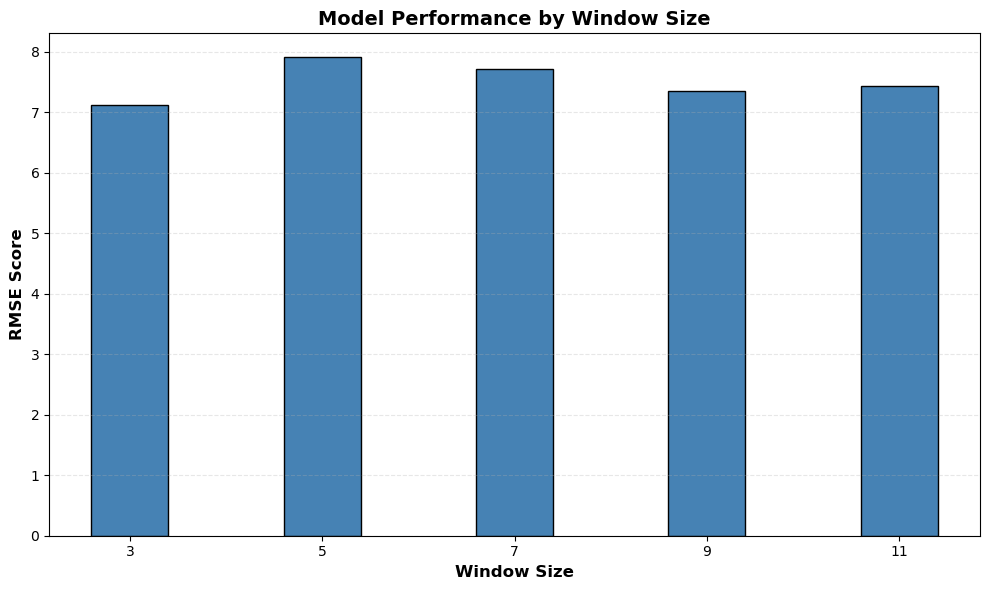

SUMMARY
Best Window Size: 3
Best RMSE Score: 7.1210

All RMSE Scores:
  Window Size 3: 7.1210
  Window Size 5: 7.9091
  Window Size 7: 7.7075
  Window Size 9: 7.3565
  Window Size 11: 7.4313


In [123]:
#stored weights and models
window_sizes = [3, 5, 7, 9, 11]
models = [model1, model2, model3, model4, model5]
weight_files = [
    'dnn/best_FCNNweights2_overall.keras',
    'dnn/best_FCNNweights3_overall.keras',
    'dnn/best_FCNNweights4_overall.keras',
    'dnn/best_FCNNweights5_overall.keras',
    'dnn/best_FCNNweights6_overall.keras'
]

#test data
test_sets = [(x1_test, y1_test), (x2_test, y2_test), (x3_test, y3_test), 
             (x4_test, y4_test), (x5_test, y5_test)]

#storage for RMSE scores
scores = []

#recursively evaluate each model
for i, (ws, model, weights, (x_test, y_test)) in enumerate(zip(window_sizes, models, weight_files, test_sets)):
    print(f"\033[1m\033[4mWindow Size: {ws}\033[0m")
    model.load_weights(weights)
    y_pred = model.predict(x_test)
    print(y_pred.shape)
    #calculate RMSE
    score = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
    scores.append(score)
    print(f"Score (RMSE): {score}")

#create bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(window_sizes, scores, color='steelblue', edgecolor='black')
plt.xlabel('Window Size', fontsize=12, fontweight='bold')
plt.ylabel('RMSE Score', fontsize=12, fontweight='bold')
plt.title('Model Performance by Window Size', fontsize=14, fontweight='bold')
plt.xticks(window_sizes)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#data summary
print("SUMMARY")
best_idx = np.argmin(scores)
print(f"Best Window Size: {window_sizes[best_idx]}")
print(f"Best RMSE Score: {scores[best_idx]:.4f}")
print("\nAll RMSE Scores:")
for ws, score in zip(window_sizes, scores):
    print(f"  Window Size {ws}: {score:.4f}")